In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
import xlrd
import os 
import sqlite3
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.impute import SimpleImputer

sns.set(style="whitegrid")

### Functions:

In [3]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

In [4]:
def classify_correlation(r):
    r = abs(r)
    if r < 0.16:
        return "very weak"
    if r < 0.29:
        return "weak"
    if r < 0.49:
        return "low"
    if r < 0.69:
        return "moderate"
    if r < 0.89:
        return "strong"
    return "very strong"

In [5]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    r = stats.pearsonr(data[x], data[y])[0]
    print( "r   =", r, f"({classify_correlation(r)})")
    rho = stats.spearmanr(data[x], data[y])[0]
    print( "rho =", rho, f"({classify_correlation(rho)})")

In [6]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [7]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

In [8]:
db_path = '../datasets/datawarehouse.db'

#### ETL - Price (for some EDA instances), host_response_rate, and host_acceptance_rate

Load the data from the `listings` table:

In [9]:
data = pd.read_sql_query("SELECT * FROM listings", sqlite3.connect('../data/datawarehouse.db'))

In [10]:
eda_dkn = data.loc[:,["price", "host_response_rate", "host_acceptance_rate"]]
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate
0,$20.00,N/A,N/A
1,$185.00,100%,100%
2,$221.00,99%,100%
3,$142.00,100%,100%
4,$398.00,N/A,N/A


We then convert categorical variables `price`, `host_response_rate`, and `host_acceptance_rate` into numerical variables.

We first remove `$` and `,` from the column of `price` and `%` from the columns of `host_response_rate` and `host_acceptance_rate`:

In [11]:
eda_dkn['price'] = eda_dkn['price'].str.replace('$', '')
eda_dkn['price'] = eda_dkn['price'].str.replace(',', '')
eda_dkn['host_response_rate'] = eda_dkn['host_response_rate'].str.replace('%', '')
eda_dkn['host_acceptance_rate'] = eda_dkn['host_acceptance_rate'].str.replace('%', '')
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate
0,20.00,N/A,N/A
1,185.00,100,100
2,221.00,99,100
3,142.00,100,100
4,398.00,N/A,N/A


We then look at how many `N/A`s are in these columns:

In [12]:
eda_dkn['price'].str.count('N/A').sum()

0

In [13]:
eda_dkn['host_response_rate'].str.count('N/A').sum()

1473

In [14]:
eda_dkn['host_acceptance_rate'].str.count('N/A').sum()

1073

We then convert `host_response_rate` and `host_acceptance_rate` to floats:

In [15]:
eda_dkn['host_response_rate'] = eda_dkn['host_response_rate'].str.replace('N/A', '')
eda_dkn['host_acceptance_rate'] = eda_dkn['host_acceptance_rate'].str.replace('N/A', '')
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate
0,20.00,,
1,185.00,100,100
2,221.00,99,100
3,142.00,100,100
4,398.00,,


In [16]:
for price in eda_dkn.columns:
    eda_dkn[price] = pd.to_numeric(eda_dkn[price], errors='coerce')

In [17]:
imputer1 = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer1 = imputer1.fit(eda_dkn[['host_response_rate']])
eda_dkn['host_response_rate'] = imputer1.transform(eda_dkn[['host_response_rate']])

imputer2 = imputer1.fit(eda_dkn[['host_acceptance_rate']])
eda_dkn['host_acceptance_rate'] = imputer2.transform(eda_dkn[['host_acceptance_rate']])
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate
0,20.0,96.885774,88.742004
1,185.0,100.000000,100.000000
2,221.0,99.000000,100.000000
3,142.0,100.000000,100.000000
4,398.0,96.885774,88.742004


Now we will add the categorical variable `host_response_time` to the dataframe:

In [18]:
eda_dkn['host_response_time'] = data['host_response_time']
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate,host_response_time
0,20.0,96.885774,88.742004,N/A
1,185.0,100.000000,100.000000,within an hour
2,221.0,99.000000,100.000000,within an hour
3,142.0,100.000000,100.000000,within an hour
4,398.0,96.885774,88.742004,N/A


Now we will replace missing values in `host_response_time` with the most frequent value:

In [19]:
eda_dkn['host_response_time'] = eda_dkn['host_response_time'].str.replace('N/A', '')
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate,host_response_time
0,20.0,96.885774,88.742004,
1,185.0,100.000000,100.000000,within an hour
2,221.0,99.000000,100.000000,within an hour
3,142.0,100.000000,100.000000,within an hour
4,398.0,96.885774,88.742004,


In [20]:
imputer3 = SimpleImputer(missing_values=None, strategy='constant', fill_value='within an hour')
imputer3 = imputer3.fit(eda_dkn[['host_response_time']])
eda_dkn[['host_response_time']] = imputer3.transform(eda_dkn[['host_response_time']])
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate,host_response_time
0,20.0,96.885774,88.742004,
1,185.0,100.000000,100.000000,within an hour
2,221.0,99.000000,100.000000,within an hour
3,142.0,100.000000,100.000000,within an hour
4,398.0,96.885774,88.742004,


We decided not to fill in the missing values in host_response_time, since it will bring up bias. 

### Target Variable: Price of AirBnB Listing

In [21]:
db_path = './datawarehouse.db'
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT id, CAST(REPLACE(price, '$', '') AS FLOAT) as avg_price
FROM listings;
'''

cur.execute(query)
con.commit()

price_arr = cur.fetchall()
con.close()

In [22]:
cost_arr = []
for pairs in price_arr:
    cost_arr.append(pairs[1])

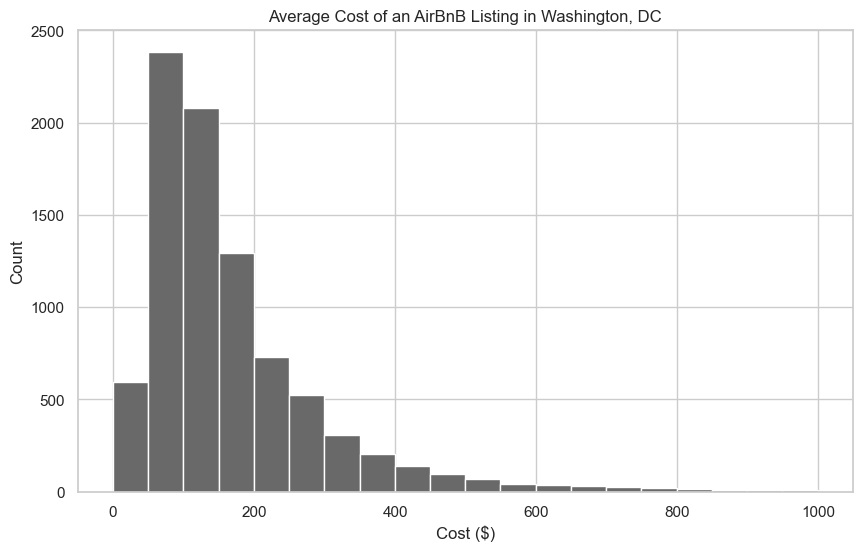

In [23]:
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 1, 1)
axes.hist(cost_arr, color="dimgray", bins=20)
axes.set_ylabel( "Count")
axes.set_xlabel( "Cost ($)")
axes.set_title( "Average Cost of an AirBnB Listing in Washington, DC")

plt.show()
plt.close()

## Single Variable EDA

### Neighborhood Groups

The neighborhood group variable is a categorical value. In Washington D.C., there are [131 neighborhoods](https://en.wikipedia.org/wiki/Neighborhoods_in_Washington,_D.C.) that are unofficially defined. The AirBnB dataset compiles neighborhood names using the city's defined borders for the neighborhoods, along with the latitude and longitude of the property listing. 

In [24]:
db_path = './datawarehouse.db'
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT neighbourhood_cleansed, COUNT(*) as neighborhood_count
FROM listings
GROUP BY neighbourhood_cleansed
ORDER BY neighborhood_count DESC;
'''

cur.execute(query)
con.commit()

neighborhood = cur.fetchall()
con.close()

# Convert to DataFrame so Pandas functions can be used for EDA
nbhd = []
n_count = []
for n in neighborhood:
    nbhd.append(n[0])
    n_count.append(n[1])
n_df = pd.DataFrame({'nbhd': nbhd,
                    'n_count': n_count})

In [25]:
n_df.sort_values(by='n_count', ascending=False)
t = tabulate(n_df, 
             headers=('Index', 'Neighborhood Grouping', 'Count'),
            tablefmt='fancy_grid')
print('     Count of AirBnB Listings, By Neighborhood')
print(t)
print('\n')

     Count of AirBnB Listings, By Neighborhood
╒═════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════╤═════════╕
│   Index │ Neighborhood Grouping                                                                             │   Count │
╞═════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════╪═════════╡
│       0 │ Union Station, Stanton Park, Kingman Park                                                         │     808 │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│       1 │ Capitol Hill, Lincoln Park                                                                        │     675 │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│       2 │ Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View                             

In this dataset, the neighborhoods are grouped based on proximity. There are 39 unique neighborhood groupings, reduced from the 131 individual neighborhoods in Washington, D.C. The neighborhood groupings with the greatest number of listings are: 
1. Capitol Hill, Union Park (561 listings)
2. Union Station, Stanton Park, Kingman Park (550 listings)
3. Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View (456 listings)

The Captiol Hill neighborhood is one of the most densely populated in Washington D.C $^{[1]}$. The Union Station neighborhood is near Washington Union Station, which is Amtrack's second-busiest station $^{[2]}$. The Columbia Heights and Mt. Pleasant areas are located close to a major University, and contains many restaurants $^{[3]}$.

*Sources*
1. https://en.wikipedia.org/wiki/Capitol_Hill
2. https://en.wikipedia.org/wiki/Washington_Union_Station
3. https://en.wikipedia.org/wiki/Columbia_Heights_(Washington,_D.C.)

### Neighborhood Groups - Tax Assessed Property Values Dataset

The secondary dataset on tax-assessed property values contains neighborhood names. The same neighborhood grouping were used in both the primary and secondary dataset. 

For the secondary datasource, any properties with a tax-assessed value of greater than 5 million USD, or less than 50 thousand USD, will be excluded. The tax-assessed value can be considered to be similar to the nightly cost of an AirBnB. Comparing the tax-assessed value by neighborhood could indicate which neighborhoods of DC are more expensive, and may also contain more expensive AirBnb listings.

In [31]:
db_path = './datawarehouse.db'
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT NBHDNAME, COUNT(*) as neighborhood_count
FROM property_info
WHERE PROPTYPE LIKE '%Residential%'
GROUP BY NBHDNAME
ORDER BY neighborhood_count DESC;
'''

cur.execute(query)
con.commit()
prop_info = cur.fetchall()

OperationalError: no such table: property_info

In [28]:
nbhd = []
count = []
for vals in prop_info:
    nbhd.append(vals[0])
    count.append(vals[1])
    
prop_df = pd.DataFrame({'nbhd': nbhd,
                       'count': count})

prop_df.sort_values(by='count', ascending=False)
t = tabulate(prop_df, 
             headers=('Index', 'Neighborhood Grouping', 'Count'),
            tablefmt='fancy_grid')
print('     Number of Properties In Neighborhoods')
print(t)
print('\n')

NameError: name 'prop_info' is not defined

The three neighborhoods with the highest number of residential properties are:
1. Capitol Hill, Lincoln Park   
2. Dupont Circle, Connecticut Avenue/K Street
3. Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View  

The "Capitol Hill, Lincoln Park" and "Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View" neighborhood groupings fall in the top three, based on count of properties, for both datasets. In the property assessed dataset, the "Union Station, Staton Park, Kingman Park" grouping ranks 29th by property count, while in the AirBnB data, it ranked second by count. The "Dupont Circle, Connecticut Avenue/K Street" grouping has the fourth highest count of AirBnB listings, and ranks second, by count, in the property assessed values.

The property assessed values dataset also includes entire apartment buildings. It may be the case that Union Station contains more group living buildings, which would limit the overall count of individual properties in the secondary dataset, since an entire apartment building may only count as one property. 

### Number of Bathrooms

The number of bathrooms in an AirBnB is a categorical value, since AirBnbs can have "shared" or "private" bathrooms. Additionally, there may be "half-baths" as well. 

In [32]:
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT bathrooms_text, COUNT(*) as num_bath
FROM listings
GROUP BY bathrooms_text
ORDER BY num_bath DESC;
'''

cur.execute(query)
con.commit()

bathroom = cur.fetchall()
con.close()

In [33]:
bath_type = []
bath_count = []
for vals in bathroom:
    bath_type.append(vals[0])
    bath_count.append(vals[1])
    
bath_df = pd.DataFrame({'bath_type': bath_type,
                       'count': bath_count})

In [34]:
bath_df.sort_values(by='count', ascending=False)
bath_df.set_index('bath_type', inplace=True)
t = tabulate(bath_df, 
             headers=('Bathroom Type', 'Count'),
            tablefmt='fancy_grid')
print('     Counts of Bathroom Types In AirBnb')
print(t)
print('\n')

     Counts of Bathroom Types In AirBnb
╒═══════════════════╤═════════╕
│ Bathroom Type     │   Count │
╞═══════════════════╪═════════╡
│ 1 bath            │    4684 │
├───────────────────┼─────────┤
│ 2 baths           │     895 │
├───────────────────┼─────────┤
│ 1 shared bath     │     642 │
├───────────────────┼─────────┤
│ 1 private bath    │     558 │
├───────────────────┼─────────┤
│ 2.5 baths         │     410 │
├───────────────────┼─────────┤
│ 1.5 baths         │     396 │
├───────────────────┼─────────┤
│ 0 shared baths    │     186 │
├───────────────────┼─────────┤
│ 3.5 baths         │     185 │
├───────────────────┼─────────┤
│ 3 baths           │     160 │
├───────────────────┼─────────┤
│ 1.5 shared baths  │     139 │
├───────────────────┼─────────┤
│ 2 shared baths    │     129 │
├───────────────────┼─────────┤
│ 2.5 shared baths  │      53 │
├───────────────────┼─────────┤
│ 4 baths           │      51 │
├───────────────────┼─────────┤
│ 4.5 baths         │      32 │


The most common bathroom type for Airbnb is "1 bath". Some listings don't have bath populated: these can be filled with the most common bathroom type, which is one bath. It may make sense to reduce the number of "types of bath" categories. This "bathroom_dict" variable can be used later in pairwise analysis.

In [35]:
'''
Limit the number of bath categories
'''
bathroom_dict = {}
bathroom_mapping = {}

def getNewBathroomCat(s):
    str_elements = s.split(' ')
    bath_cat = ''
    if str_elements[0] == '':
        bath_cat = '1 Private'
    elif str_elements[0] == 'Half-bath':
        bath_cat = '1 Private'
    elif str_elements[0] == '0':
        bath_cat = '1 Private'
    else:
        try:
            num_bath = float(str_elements[0])
            if num_bath >= 3:
                bath_cat = '3+'
            elif num_bath >= 2:
                bath_cat = '2'
            else:
                bath_cat = '1'
            if str_elements[1] == 'shared':
                bath_cat += ' Shared'
            else:
                bath_cat += ' Private'
        except:
            if str_elements[0] == 'Private':
                bath_cat = '1 Private'
            elif str_elements[0] == 'Shared':
                bath_cat = '1 Shared'
    return bath_cat
    
for ind in range(0, len(bath_type)):
    s = bath_type[ind]
    c = bath_count[ind]
    
    b_type = getNewBathroomCat(s)
    bathroom_mapping[s] = b_type

    if b_type not in bathroom_dict:
        bathroom_dict[b_type] = c
    else:
        bathroom_dict[b_type] +=c

In [36]:
lim_bath_df = pd.DataFrame({'bath_type': bathroom_dict.keys(), 'count': bathroom_dict.values()})

lim_bath_df.sort_values(by='count', ascending=False)
lim_bath_df.set_index('bath_type', inplace=True)
t = tabulate(lim_bath_df, 
             headers=('Bathroom Type', 'Count'),
            tablefmt='fancy_grid')
print('     Counts of Bathroom Types In AirBnb')
print(t)
print('\n')

     Counts of Bathroom Types In AirBnb
╒═════════════════╤═════════╕
│ Bathroom Type   │   Count │
╞═════════════════╪═════════╡
│ 1 Private       │    5837 │
├─────────────────┼─────────┤
│ 2 Private       │    1305 │
├─────────────────┼─────────┤
│ 1 Shared        │     782 │
├─────────────────┼─────────┤
│ 3+ Private      │     448 │
├─────────────────┼─────────┤
│ 2 Shared        │     182 │
├─────────────────┼─────────┤
│ 3+ Shared       │      74 │
╘═════════════════╧═════════╛




### "Is Superhost" query

Some hosts on AirBnB are marked as Superhosts. This is a specific Airbnb program that "celebrates and rewards Airbnb's top-rated and most experienced hosts". These hosts must meet the following critera:
- 4.8+ overall rating
- 10+ stays
- <1% cancellation rate
- 90% response rate

This is a categorical, boolean value, with the host either being labeled as a superhost, or not being labeled as a superhost.

*Sources:*
1. https://www.airbnb.com/d/superhost

In [37]:
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT host_is_superhost, COUNT(*) as num_superhosts
FROM listings
GROUP BY host_is_superhost
ORDER BY num_superhosts DESC;
'''

cur.execute(query)
con.commit()

superhost = cur.fetchall()

con.close()

In [38]:
s_status = []
count = []
for vals in superhost:
    s_status.append(vals[0])
    count.append(vals[1])
    
super_df = pd.DataFrame({'s_status': s_status,
                       'count': count})

super_df.set_index('s_status', inplace=True)
t = tabulate(super_df, 
             headers=('Is Superhost', 'Count'),
            tablefmt='fancy_grid')
print('     Number of Properties In Neighborhoods')
print(t)
print('\n')

     Number of Properties In Neighborhoods
╒════════════════╤═════════╕
│ Is Superhost   │   Count │
╞════════════════╪═════════╡
│ f              │    6185 │
├────────────────┼─────────┤
│ t              │    2439 │
├────────────────┼─────────┤
│                │       4 │
╘════════════════╧═════════╛




In the AirBnB listings, 4496 of the listings have hosts that are not superhosts. This is about 70% of all listings. The other 30%, or 1972 listings, are labeled as superhosts. Five of the points in the dataset are not labeled, and thuse should be treated as `is_superhost=False`.

### Bedrooms
The bedrooms variable is a numerical integer value. The `beds` variable represents the number of beds in the AirBnb. More beds generally corresponds to a higher capacity for overnight guests.

In [39]:
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT id, CAST(bedrooms AS INT), CAST(beds AS INT), CAST(accommodates AS INT), CAST(REPLACE(price, '$', '') AS FLOAT)
FROM listings;'''

cur.execute(query)
con.commit()

b_arr = cur.fetchall()

In [40]:
b_arr[0]

(22229408, 1, 1, 2, 20.0)

The SQL query returns a list of tuple objects, with:
- `b_arr[0]`: listing_id
- `b_arr[1]`: bedrooms
- `b_arr[2]`: beds
- `b_arr[3]`: accommodates
- `b_arr[4]`: price

In [41]:
listing_id = []
bedrooms = []
beds = []
accommodates = []
price = []
for b in b_arr:
    listing_id.append(b[0])
    bedrooms.append(b[1])
    beds.append(b[2])
    accommodates.append(b[3])
    price.append(b[4])
    
b_df = pd.DataFrame({'listing_id': listing_id,
                    'bedrooms': bedrooms,
                    'beds': beds,
                    'accommodates': accommodates,
                    'price': price})

b_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8628 entries, 0 to 8627
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   listing_id    8628 non-null   int64  
 1   bedrooms      8628 non-null   int64  
 2   beds          8628 non-null   int64  
 3   accommodates  8628 non-null   int64  
 4   price         8628 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 337.2 KB


The variables `beds`, `bedrooms`, and `accommodates` are all integer values. The `price` variable is a float value. 

In [42]:
b_df.beds.describe()

count    8628.000000
mean        1.930111
std         1.405451
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        20.000000
Name: beds, dtype: float64

75% of AirBnB listings in the DC area contain two or fewer bedrooms. There is one AirBnB that has a maximum number of bedrooms of 15. 

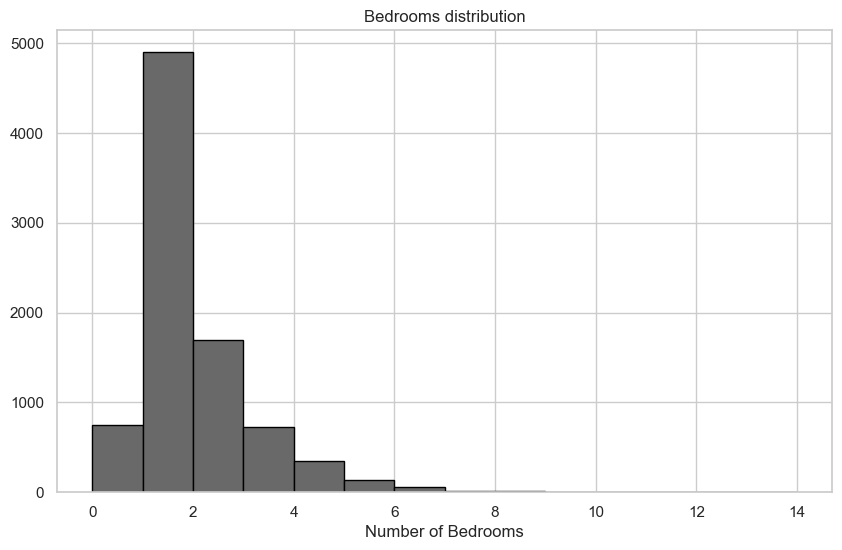

In [43]:
h=1
mn = int(b_df["bedrooms"].min())
mx = int(b_df["bedrooms"].max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(b_df["bedrooms"],bins=bins, histtype='bar', color="DimGray", ec='black')
axes.set_title("Bedrooms distribution")
axes.set_xlabel("Number of Bedrooms")

plt.show()
plt.close()

The distribution of the number of bedrooms appears to be right-skewed. This makes sense, as one or two bedrooms may be common for most homes, with 3 or more bedrooms being less commons in homes, especially in a densely-populated area.

### Accommodates
The `accommodates` variable is a numerical integer value. The `accommodates` variable represents the number of beds in the AirBnb. More beds generally corresponds to a higher capacity for overnight guests.

In [44]:
b_df.accommodates.describe()

count    8628.000000
mean        3.632592
std         2.389346
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        16.000000
Name: accommodates, dtype: float64

75% of AirBnB listings in the DC area are capable of accomodating 4 people. This unsurprisingly folows a similar pattern to both the `beds` and `bedroom` variables.

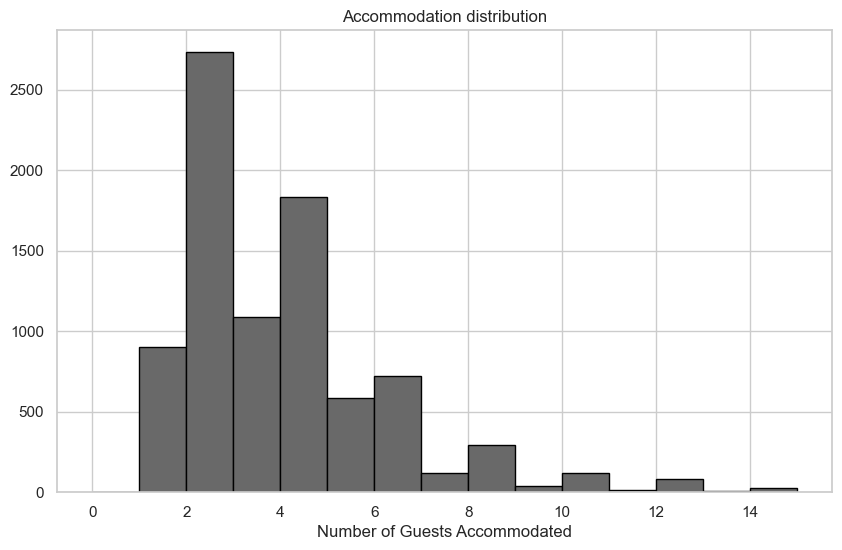

In [45]:
h=1
mn = int(b_df["accommodates"].min())
mx = int(b_df["accommodates"].max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(b_df["accommodates"],bins=bins, histtype='bar', color="DimGray", ec='black')
axes.set_title("Accommodation distribution")
axes.set_xlabel("Number of Guests Accommodated")

plt.show()
plt.close()

The data are once again right-skewed. Even number `accommodates` values are more common, which makes sense given that one bed is often counted as accommodating 2 guests.

### Host Response Time

`host_response_time` is a categorical variable. More specifically, it is a variable that takes values of a few days or more, within a day, within a few hours, and within an hour. We can get a distribution of its values using `value_counts()`:

In [46]:
eda_dkn["host_response_time"].value_counts().sort_index()

                      1493
a few days or more      91
within a day           562
within a few hours    1099
within an hour        5383
Name: host_response_time, dtype: int64

Interestingly, the dataset has the highest number of within an hour, the second highest number of within a few hours, the 3rd highest number of with a day and the lowest as a few days or more. This suggests that the host tends to respond quickly in order to rent out their houses.

### Host Response Rate

`host_response_rate` is a numerical variable that measures the percentages that the host will respond. We would expect that the price of the Airbnb will increase with the increase of the host_response_rate. Let's get a sense of the range of this variable by looking at the summary statistics:

In [47]:
eda_dkn["host_response_rate"].describe()

count    8628.000000
mean       96.885774
std        10.176818
min         0.000000
25%        96.885774
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

The minimum `host_response_rate` is 0 which means that the host never responded and the maximum is 100%. This is a big range which tells me that the variable is definitely skewed. The mean is 96.9 and the median is 100 which suggests a left skewness. Recall that when the mean < median, this suggest a left- skewed distribution. Let's plot a histogram of the data using Freeman Diaconis bins. The use of Freeman Diaconis bins allows us to select the width of the bins to be used in a histogram. 

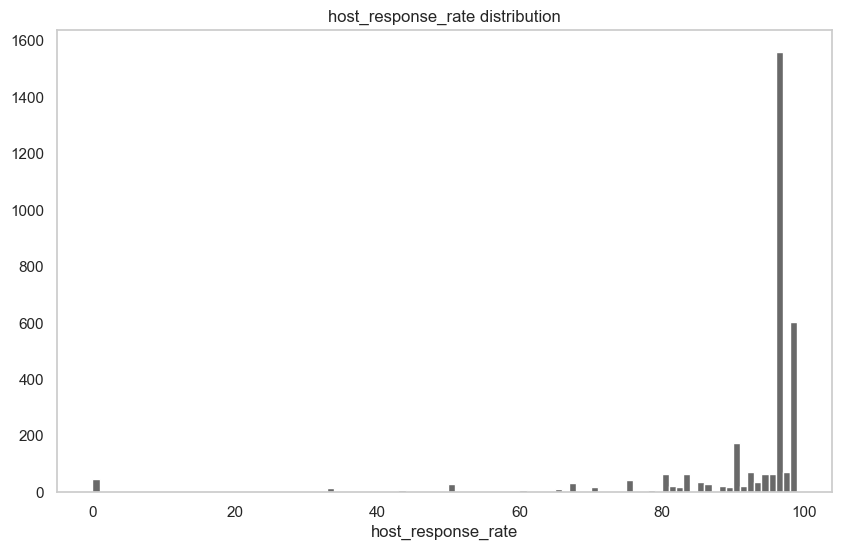

In [48]:
# Ref: Fundamentals
mn = int(eda_dkn.host_response_rate.min())
mx = int(eda_dkn.host_response_rate.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(eda_dkn.host_response_rate,bins=bins, color="DimGray", edgecolor = "white")
axes.set_title("host_response_rate distribution")
axes.set_xlabel("host_response_rate")
axes.grid()

plt.show()
plt.close()

The distribution of the data looks very much skewed left which makes some sense given if the host responds more, the price will go up.

### Host Acceptance Rate

`host_acceptance_rate` is a numerical variable that measures percentages of host accepts the requests. Similarly, we should expect that the price would go up with the increase of the host_acceptance_rate. Let's get a sense of the range of this variable by looking at the summary statistics:

In [49]:
eda_dkn["host_acceptance_rate"].describe()

count    8628.000000
mean       88.742004
std        18.887827
min         0.000000
25%        88.742004
50%        97.000000
75%       100.000000
max       100.000000
Name: host_acceptance_rate, dtype: float64

The variable is definitely skewed left. The mean is 88.7% and the median is 97.0%. The 1st quartile is the same as the mean while the 3rd quartile is 100%. Let's plot a histogram of the data using Freeman Diaconis bins: 

Freeman Diaconis:  1


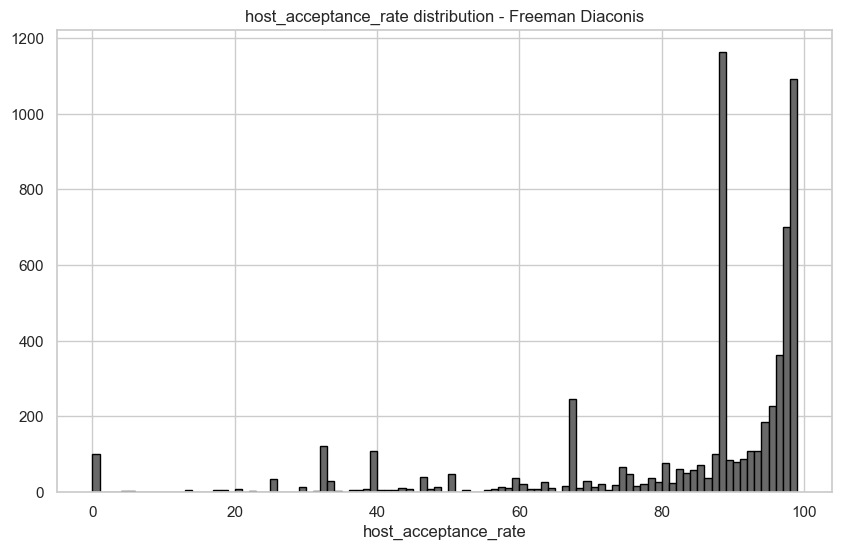

In [50]:
h = freeman_diaconis(eda_dkn["host_acceptance_rate"])
print("Freeman Diaconis: ", h)
mn = int(eda_dkn["host_acceptance_rate"].min())
mx = int(eda_dkn["host_acceptance_rate"].max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(eda_dkn["host_acceptance_rate"],bins=bins, histtype='bar', color="DimGray", ec='black')
axes.set_title("host_acceptance_rate distribution - Freeman Diaconis")
axes.set_xlabel("host_acceptance_rate")

plt.show()
plt.close()

The distribution of the data is skewed left. Similarly, if we assume that the price will depend on the increase of host_acceptance_rate, it created this skewness. 

In [51]:
db_path = './datawarehouse.db'
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT id, AVG(number_of_reviews) as avg_rev
FROM listings
GROUP BY id;
'''

cur.execute(query)
con.commit()

number_of_reviews = cur.fetchall()

con.close()

In [52]:
number_of_reviews = pd.DataFrame(number_of_reviews, columns=['ID', 'Average # of Reviews'])
number_of_reviews

,ID,Average # of Reviews
0,3571,9.0
1,3686,81.0
2,3943,455.0
3,4197,52.0
4,4373,24.0
...,...,...
8623,849293688249908869,0.0
8624,849304474004984024,0.0
8625,849310766288741827,0.0
8626,849479534479786096,0.0


In [53]:
number_of_reviews['Average # of Reviews'].describe()

count    8628.000000
mean       44.930227
std        82.225549
min         0.000000
25%         0.000000
50%        10.000000
75%        51.000000
max       898.000000
Name: Average # of Reviews, dtype: float64

Freeman Diaconis:  4


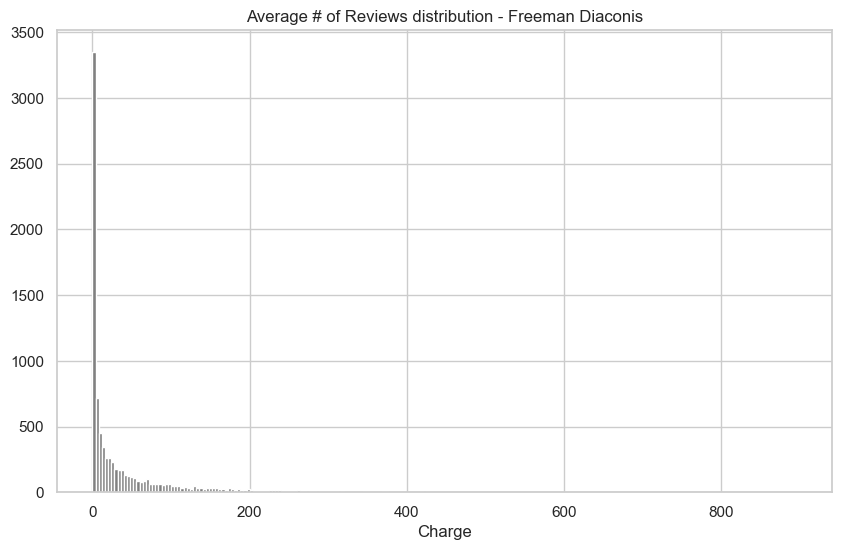

In [54]:
h = freeman_diaconis(number_of_reviews ['Average # of Reviews'])
print('Freeman Diaconis: ', h)
mn = int(number_of_reviews['Average # of Reviews'].min())
mx = int(number_of_reviews['Average # of Reviews'].max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(number_of_reviews['Average # of Reviews'],bins=bins, color='gray')
axes.set_title('Average # of Reviews distribution - Freeman Diaconis')
axes.set_xlabel('Charge')

plt.show()
plt.close()

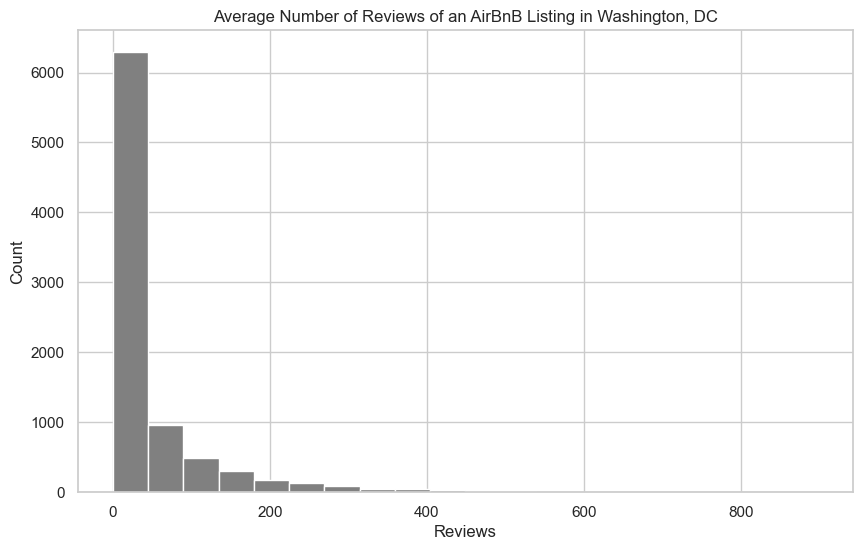

In [55]:
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 1, 1)

axes.hist(number_of_reviews['Average # of Reviews'], color='gray', bins=20)
axes.set_ylabel('Count')
axes.set_xlabel('Reviews')
axes.set_title('Average Number of Reviews of an AirBnB Listing in Washington, DC')

plt.show()
plt.close()

### Review Scores Rating

In [56]:
db_path = './datawarehouse.db'
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT id, AVG(review_scores_rating) AS FLOAT
FROM listings
GROUP BY id;
'''

cur.execute(query)
con.commit()

review_scores_rating = cur.fetchall()

con.close()

In [57]:
review_scores_rating = pd.DataFrame(review_scores_rating, columns=['ID', 'Average Review Scores'])
review_scores_rating

,ID,Average Review Scores
0,3571,4.50
1,3686,4.63
2,3943,4.82
3,4197,4.84
4,4373,4.90
...,...,...
8623,849293688249908869,0.00
8624,849304474004984024,0.00
8625,849310766288741827,0.00
8626,849479534479786096,0.00


In [58]:
review_scores_rating['Average Review Scores'].describe()

count    8628.000000
mean        3.506911
std         2.095967
min         0.000000
25%         0.000000
50%         4.730000
75%         4.920000
max         5.000000
Name: Average Review Scores, dtype: float64

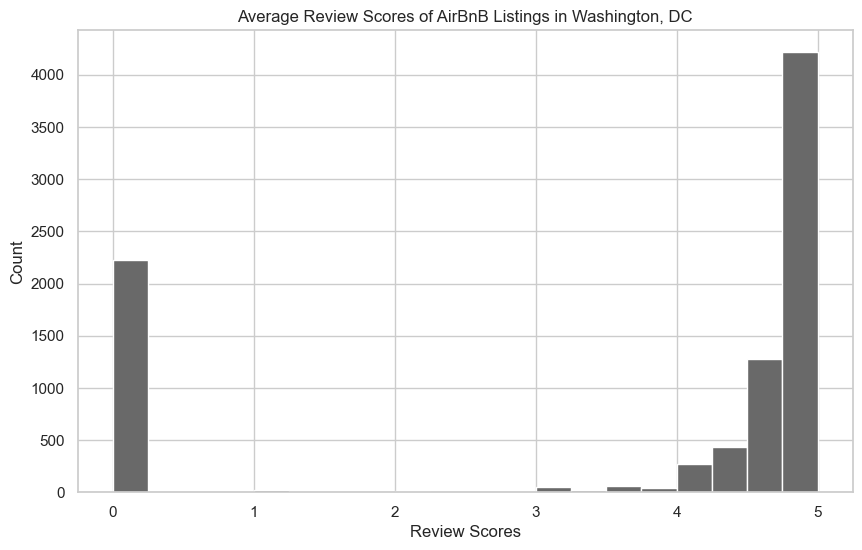

In [59]:
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 1, 1)

axes.hist(review_scores_rating['Average Review Scores'], color='dimgray', bins=20)
axes.set_ylabel('Count')
axes.set_xlabel('Review Scores')
axes.set_title('Average Review Scores of AirBnB Listings in Washington, DC')

plt.show()
plt.close()

### Reviews Per Month

In [60]:
db_path = './datawarehouse.db'
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT id, AVG(reviews_per_month) AS FLOAT
FROM listings
GROUP BY id;
'''

cur.execute(query)
con.commit()

reviews_per_month = cur.fetchall()

con.close()

In [61]:
reviews_per_month = pd.DataFrame(reviews_per_month, columns=['ID', 'Average Reviews Per Month'])
reviews_per_month

,ID,Average Reviews Per Month
0,3571,0.06
1,3686,0.54
2,3943,2.70
3,4197,0.31
4,4373,0.14
...,...,...
8623,849293688249908869,0.00
8624,849304474004984024,0.00
8625,849310766288741827,0.00
8626,849479534479786096,0.00


In [62]:
reviews_per_month['Average Reviews Per Month'].describe()

count    8628.000000
mean        1.286619
std         1.906288
min         0.000000
25%         0.000000
50%         0.510000
75%         1.970000
max        59.650000
Name: Average Reviews Per Month, dtype: float64

### Room Type

In [63]:
db_path = './datawarehouse.db'
con=sqlite3.connect(db_path)
cur = con.cursor()

sql_query = pd.read_sql_query('''SELECT room_type, property_type, instant_bookable, price
FROM listings''', con)

df = pd.DataFrame(sql_query, columns = ['room_type', 'price', 'instant_bookable', 'property_type'])
df

,room_type,price,instant_bookable,property_type
0,Private room,$20.00,f,Private room in townhouse
1,Entire home/apt,$185.00,f,Entire townhouse
2,Entire home/apt,$221.00,f,Entire rental unit
3,Entire home/apt,$142.00,t,Entire guest suite
4,Entire home/apt,$398.00,t,Entire rental unit
...,...,...,...,...
8623,Entire home/apt,$70.00,f,Entire condo
8624,Entire home/apt,$253.00,t,Entire serviced apartment
8625,Entire home/apt,$95.00,t,Entire condo
8626,Entire home/apt,$180.00,t,Entire serviced apartment


In [64]:
# this changes price from currency to a float
df["price"] = df["price"].replace("[$,]", "", regex=True).astype(float)

In [65]:
df.room_type.value_counts()

Entire home/apt    6455
Private room       2028
Shared room         123
Hotel room           22
Name: room_type, dtype: int64

Roughly 74.8% of the listings are categorized as entire home or apartment, 23.5% of listings are categorized as a private room, 1.4% of listings are categorized as a shared room, and less than 1% is categorized as a hotel room.

### Instant Bookable

In [66]:
df.instant_bookable.value_counts()

f    5767
t    2861
Name: instant_bookable, dtype: int64

Approximately 69% of the observed listings are not available to instantly book, whereas 31% of listings are available to be instantly booked.

### Property Type

In [67]:
df.property_type.value_counts()

Entire rental unit                    2819
Entire home                            935
Private room in home                   746
Entire condo                           673
Entire serviced apartment              655
Entire townhouse                       630
Entire guest suite                     552
Private room in rental unit            506
Private room in townhouse              354
Room in boutique hotel                 120
Room in hotel                           98
Private room in condo                   82
Entire guesthouse                       79
Shared room in rental unit              50
Private room in bed and breakfast       45
Private room in guest suite             42
Entire loft                             37
Shared room in townhouse                29
Shared room in home                     21
Room in aparthotel                      19
Shared room in hostel                   17
Entire vacation home                    17
Entire bungalow                         11
Room in hos

While this is a categorical variable, it seems some of the listing property types have unique names/titles that only relate to one or a few listings, causing a large number of buckets/options.

## Pairwise Variable EDA

### Price vs. Bathroom Type

Comparing the AirBnb listing price means that a numerical value (price) will be compared to a categorical variable (bathroom type). 

In [68]:
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT id, CAST(REPLACE(price, '$', '') AS FLOAT), bathrooms_text FROM listings'''

cur.execute(query)
con.commit()

price_bathroom = cur.fetchall()
con.close()

In [69]:
listing_id = []
price = []
bath = []

for pb in price_bathroom:
    listing_id.append(pb[0])
    price.append(pb[1])
    bath.append(bathroom_mapping[pb[2]])
price_bath_df = pd.DataFrame({'listing_id': listing_id,
                             'price': price,
                             'bath': bath})

grouped_price_bath = price_bath_df.groupby('bath')
grouped_price_bath = grouped_price_bath['price'].describe()

t = tabulate(grouped_price_bath, 
             headers=('Bathroom Type', 'Count', 'Mean', 'Stdev', 'Min', '25%', '50%', '75%', 'Max'),
            tablefmt='fancy_grid')
print(t)
print('\n')

╒═════════════════╤═════════╤══════════╤══════════╤═══════╤════════╤═══════╤════════╤═══════╕
│ Bathroom Type   │   Count │     Mean │    Stdev │   Min │    25% │   50% │    75% │   Max │
╞═════════════════╪═════════╪══════════╪══════════╪═══════╪════════╪═══════╪════════╪═══════╡
│ 1 Private       │    5837 │ 146.657  │  93.808  │     0 │  89    │ 125   │ 176    │   999 │
├─────────────────┼─────────┼──────────┼──────────┼───────┼────────┼───────┼────────┼───────┤
│ 1 Shared        │     782 │  70.4514 │  59.8362 │     1 │  44    │  58   │  80    │   999 │
├─────────────────┼─────────┼──────────┼──────────┼───────┼────────┼───────┼────────┼───────┤
│ 2 Private       │    1305 │ 266.436  │ 149.501  │     1 │ 170    │ 235   │ 329    │   999 │
├─────────────────┼─────────┼──────────┼──────────┼───────┼────────┼───────┼────────┼───────┤
│ 2 Shared        │     182 │  78.2363 │  72.4957 │    25 │  44    │  56.5 │  91.75 │   750 │
├─────────────────┼─────────┼──────────┼──────────┼───────┼─

The IQR differs between the bathroom types available in the listings. AirBnB listings with shared bathrooms have similar nightly prices, with median values ranging from 52-58 USD per night. For listings that have private bathrooms, there is a significant difference in the meidan values. The median nightly cost of an AirBnB listing with 1 private bathroom is 120 USD per night. For listings with two private bathrooms, the nightly cost jumps to 225 USD. The median for listings with three or more private bathrooms is 300 USD per night. 

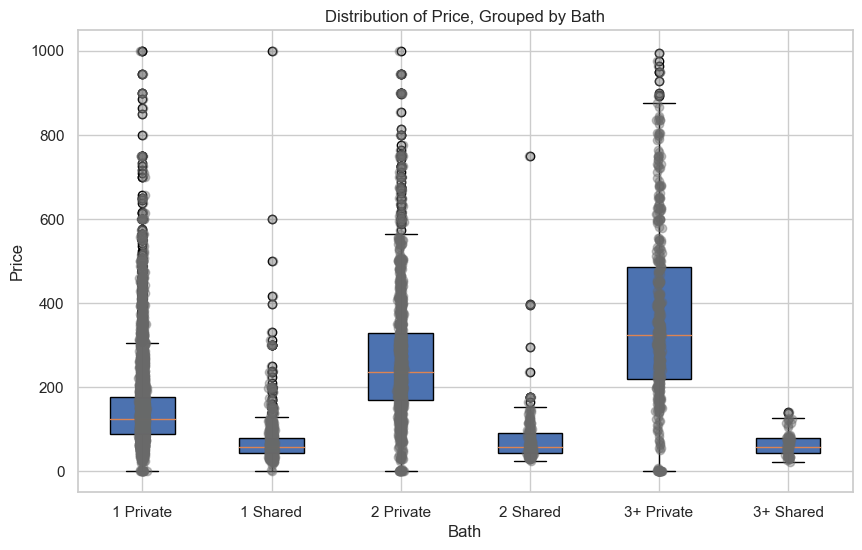

In [70]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
grouped_price_bath = price_bath_df.groupby('bath')
price_data = [grouped_price_bath.get_group(bath)['price'] for bath in grouped_price_bath.groups]

patch = axes.boxplot(price_data, labels=grouped_price_bath.groups.keys(), patch_artist=True, zorder=1)

for i, bath in enumerate(grouped_price_bath.groups.keys()):
    subdata = grouped_price_bath.get_group(bath)['price']
    x = np.random.normal(i + 1, 0.01, size=len(subdata))
    axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)

axes.set_xlabel('Bath')
axes.set_ylabel('Price')
axes.set_title('Distribution of Price, Grouped by Bath')
plt.show()
plt.close()

For listings with private bathrooms, the prices tend to increase with more bathrooms. Listings that have shared bathrooms appear to have the same values, regardless of how many shared baths are available.

### Price vs. Neighborhood Group

To compare the listing price to the neighborhood group, the IQR needs to be calculated for each of the 39 neighborhood groupings.

In [71]:
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT id, CAST(REPLACE(price, '$', '') AS FLOAT), neighbourhood_cleansed FROM listings'''

cur.execute(query)
con.commit()

nbh_price = cur.fetchall()
con.close()

In [72]:
listing_id = []
price = []
nbhd = []

for pb in nbh_price:
    listing_id.append(pb[0])
    price.append(pb[1])
    nbhd.append(pb[2])
    
nbhd_df = pd.DataFrame({'listing_id': listing_id,
                             'price': price,
                             'nbhd': nbhd})

nbhd_grouped = nbhd_df.groupby('nbhd')
nbhd_grouped = nbhd_grouped['price'].describe()
nbhd_grouped= nbhd_grouped.sort_values('count', ascending=False)

print(nbhd_grouped)

                                                    count        mean  \
nbhd                                                                    
Union Station, Stanton Park, Kingman Park           808.0  193.827970   
Capitol Hill, Lincoln Park                          675.0  174.321481   
Columbia Heights, Mt. Pleasant, Pleasant Plains...  609.0  143.783251   
Edgewood, Bloomingdale, Truxton Circle, Eckington   603.0  153.291874   
Dupont Circle, Connecticut Avenue/K Street          562.0  201.268683   
Shaw, Logan Circle                                  491.0  187.562118   
Ivy City, Arboretum, Trinidad, Carver Langston      426.0  160.154930   
Brightwood Park, Crestwood, Petworth                420.0  127.009524   
Georgetown, Burleith/Hillandale                     402.0  208.599502   
Downtown, Chinatown, Penn Quarters, Mount Verno...  314.0  225.675159   
Howard University, Le Droit Park, Cardozo/Shaw      297.0  170.185185   
West End, Foggy Bottom, GWU                        

The IQR differs between the bathroom types available in the listings. AirBnB listings with shared bathrooms have similar nightly prices, with median values ranging from 52-58 USD per night. For listings that have private bathrooms, there is a significant difference in the meidan values. The median nightly cost of an AirBnB listing with 1 private bathroom is 120 USD per night. For listings with two private bathrooms, the nightly cost jumps to 225 USD. The median for listings with three or more private bathrooms is 300 USD per night. 

Some neighborhoods tend to have higher median AirBnb Listing prices. Limiting the comparison to the neighborhoods that have at least 300 AirBnB listings:

In [73]:
nbhd_grouped = nbhd_grouped[nbhd_grouped['count']>300]
print(nbhd_grouped)

                                                    count        mean  \
nbhd                                                                    
Union Station, Stanton Park, Kingman Park           808.0  193.827970   
Capitol Hill, Lincoln Park                          675.0  174.321481   
Columbia Heights, Mt. Pleasant, Pleasant Plains...  609.0  143.783251   
Edgewood, Bloomingdale, Truxton Circle, Eckington   603.0  153.291874   
Dupont Circle, Connecticut Avenue/K Street          562.0  201.268683   
Shaw, Logan Circle                                  491.0  187.562118   
Ivy City, Arboretum, Trinidad, Carver Langston      426.0  160.154930   
Brightwood Park, Crestwood, Petworth                420.0  127.009524   
Georgetown, Burleith/Hillandale                     402.0  208.599502   
Downtown, Chinatown, Penn Quarters, Mount Verno...  314.0  225.675159   

                                                           std   min     25%  \
nbhd                                       

The "Brightwood Park, Crestwood, Petworth" neighborhoods appear to have lower nightly costs of AirbnB listings. In contrast, the "Georgetown, Burleith/Hillandale" area appears to have the highest nightly costs for AirBnbs.

In [74]:
nbhd_groups = nbhd_grouped.index

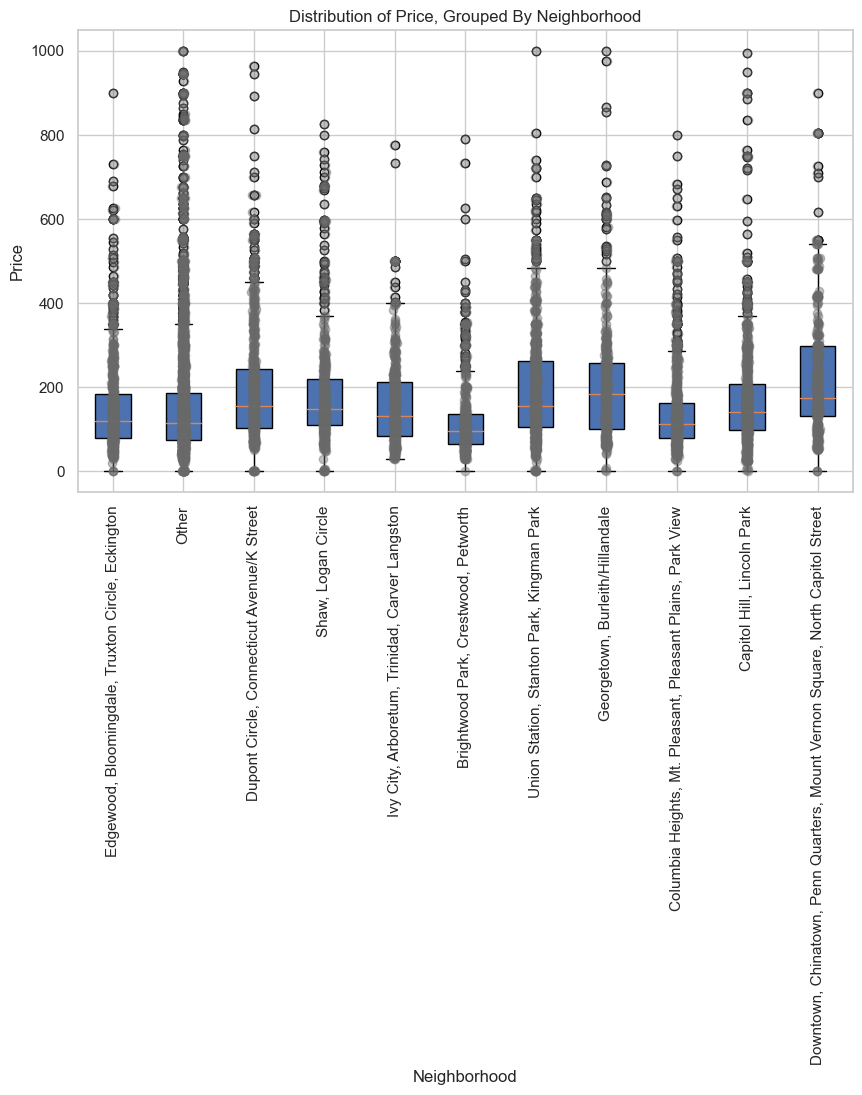

In [75]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

n_list = nbhd_grouped.index.unique()
nbhd_df.loc[~nbhd_df['nbhd'].isin(nbhd_groups), 'nbhd'] = 'Other'

labels = pd.unique(nbhd_df['nbhd'].values)
grouped_data = [nbhd_df["price"].loc[nbhd_df['nbhd'] == k] for k in labels]
patch = axes.boxplot(grouped_data, labels=labels, patch_artist=True, zorder=1)

for i, k in enumerate(labels):
    subdata = nbhd_df["price"].loc[nbhd_df['nbhd'] == k]
    x = np.random.normal(i + 1, 0.01, size=len(subdata))
    axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)

axes.set_xlabel("Neighborhood")
axes.set_ylabel("Price")
axes.set_title("Distribution of Price, Grouped By Neighborhood")
axes.set_xticklabels(labels, rotation=90)
plt.show()
plt.close()

The IQR of the pricing by neighborhood suggests that there is not a massive difference in prices of AirBnb listings depending on neighborhood. It does appear that the "Brightwood Park, Crestwood, Petworth" neighborhoods have an overall lower nightly cost.

### Price vs. Superhost Status

Around 30% of the AirBnB listings have hosts who also possess the superhost status. This status is advertised as AirBnb as being a factor in providing hosts with more success in bookings. This could mean that the hosts are able to list properties at a higher price.

In [76]:
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT id, CAST(REPLACE(price, '$', '') AS FLOAT), host_is_superhost
FROM listings;
'''

cur.execute(query)
con.commit()

super_price = cur.fetchall()
con.close()

In [77]:
listing_id = []
superhost = []
price = []

for pb in super_price:
    listing_id.append(pb[0])
    price.append(pb[1])
    if pb[2] == '':
        superhost.append('f')
    else:
        superhost.append(pb[2])
super_df = pd.DataFrame({'listing_id': listing_id,
                             'price': price,
                             'superhost': superhost})

super_df['superhost'] = super_df['superhost'].replace({'t': 'Superhost',
                                                    'f': 'Not Superhost'})

grouped_super = super_df.groupby('superhost')
grouped_super = grouped_super['price'].describe()

t = tabulate(grouped_super, 
             headers=('Is Superhost?', 'Count', 'Mean', 'Stdev', 'Min', '25%', '50%', '75%', 'Max'),
            tablefmt='fancy_grid')
print(t)
print('\n')

╒═════════════════╤═════════╤═════════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ Is Superhost?   │   Count │    Mean │   Stdev │   Min │   25% │   50% │   75% │   Max │
╞═════════════════╪═════════╪═════════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ Not Superhost   │    6189 │ 163.101 │ 128.639 │     0 │  80   │   127 │   202 │   999 │
├─────────────────┼─────────┼─────────┼─────────┼───────┼───────┼───────┼───────┼───────┤
│ Superhost       │    2439 │ 176.197 │ 135.771 │     1 │  94.5 │   135 │   200 │   963 │
╘═════════════════╧═════════╧═════════╧═════════╧═══════╧═══════╧═══════╧═══════╧═══════╛




The IQR values for superhosts and regular hosts are similar, with some minor variations. There does not to appear a significant difference between the price of a listing and the host's "superhost" status.

### Number of Bedrooms vs. Price

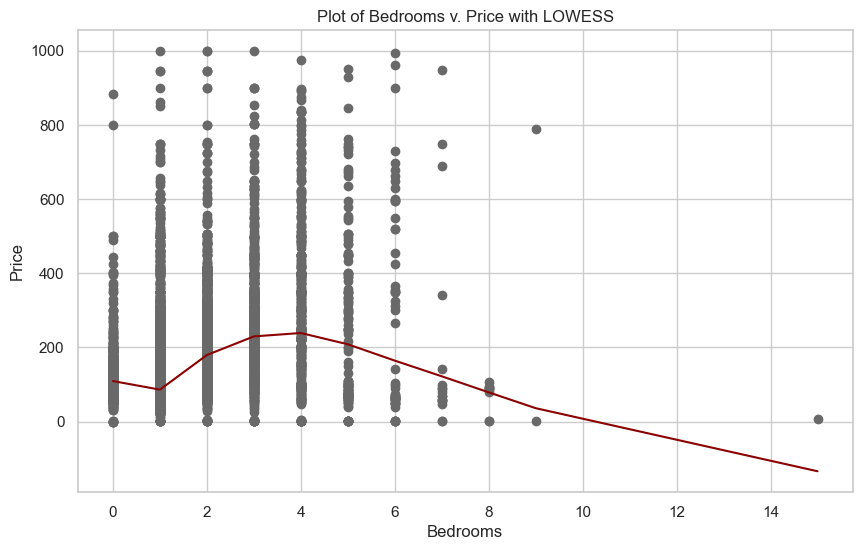

In [78]:
lowess = sm.nonparametric.lowess(b_df["price"], b_df["bedrooms"], frac=.3)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( b_df[ "bedrooms"], b_df["price"], marker="o", color="DimGray")
axes.plot(lowess_x, lowess_y, color="DarkRed")

axes.set_title("Plot of Bedrooms v. Price with LOWESS")
axes.set_xlabel( "Bedrooms")
axes.set_ylabel( "Price")

plt.show()
plt.close()

In [79]:
correlation(b_df, 'bedrooms', 'price')

Correlation coefficients:
r   = 0.39195580522733553 (low)
rho = 0.41556405657148726 (low)


### Beds v. Price with LOWESS

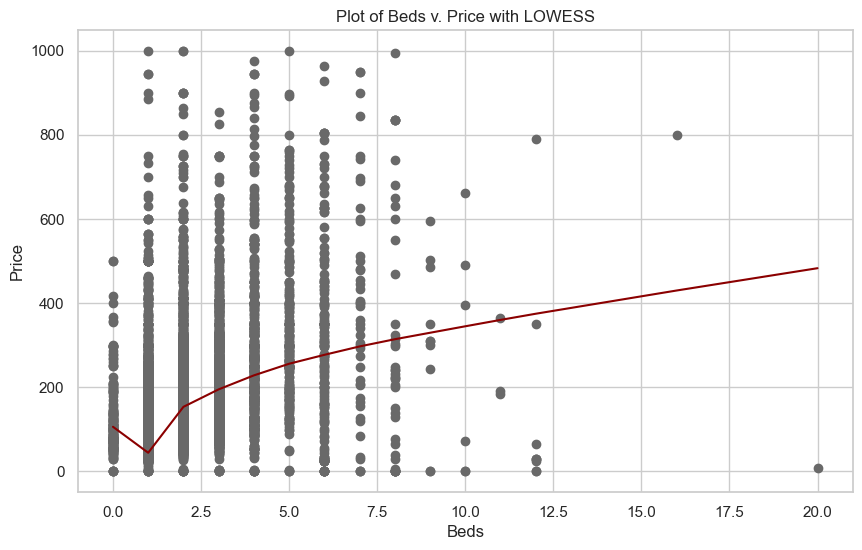

In [80]:
lowess = sm.nonparametric.lowess(b_df["price"], b_df["beds"], frac=.3)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( b_df[ "beds"], b_df["price"], marker="o", color="DimGray")
axes.plot(lowess_x, lowess_y, color="DarkRed")

axes.set_title("Plot of Beds v. Price with LOWESS")
axes.set_xlabel( "Beds")
axes.set_ylabel( "Price")

plt.show()
plt.close()

In [81]:
correlation(b_df, 'beds', 'price')

Correlation coefficients:
r   = 0.4218706196242424 (low)
rho = 0.45671345442335864 (low)


### Accommodates v. Price with LOWESS

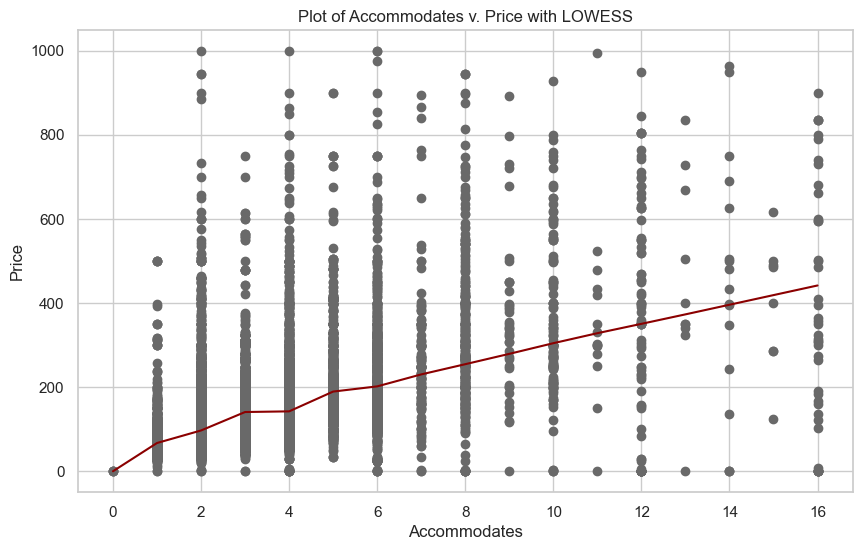

In [82]:
lowess = sm.nonparametric.lowess(b_df["price"], b_df["accommodates"], frac=.3)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( b_df[ "accommodates"], b_df["price"], marker="o", color="DimGray")
axes.plot(lowess_x, lowess_y, color="DarkRed")

axes.set_title("Plot of Accommodates v. Price with LOWESS")
axes.set_xlabel( "Accommodates")
axes.set_ylabel( "Price")

plt.show()
plt.close()

In [83]:
correlation(b_df, 'accommodates', 'price')

Correlation coefficients:
r   = 0.5080500299054234 (moderate)
rho = 0.5535062939394848 (moderate)


### Price vs Host Response Rate

We can definitely expect to see the higher the host_response_rate, the higher the price is. Since this pairwise comparison is between two numerical variables, we can start by seeing the correlation of the two variables. 

In [84]:
correlation(eda_dkn, "host_response_rate", "price")

Correlation coefficients:
r   = 0.0034642167787886885 (very weak)
rho = 0.03179421676325014 (very weak)


Pearson's correlation coefficient, $r$, is only 0.003 which indicates a very weak positive relationship. Spearman's is at 0.032 which might indicate a very weak monotonic relationship. Let's plot the data using Lowess. That is by using locally weighted smoothing (LOWESS), this method of regression analysis creates a smooth line through a scatterplot in order to see the trend between both variables. 

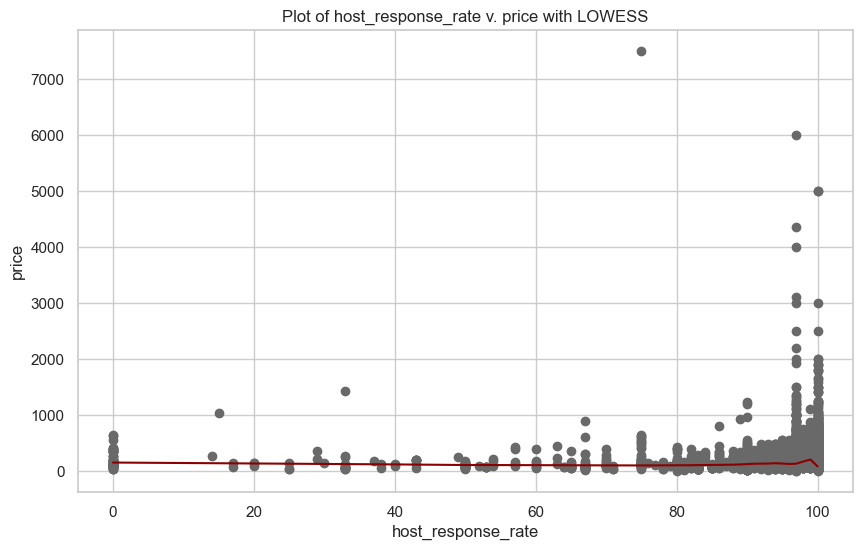

In [85]:
lowess = sm.nonparametric.lowess(eda_dkn["price"], eda_dkn["host_response_rate"], frac=.3)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( eda_dkn["host_response_rate"], eda_dkn["price"], marker="o", color="DimGray")
axes.plot(lowess_x, lowess_y, color="DarkRed")

axes.set_title("Plot of host_response_rate v. price with LOWESS")
axes.set_xlabel( "host_response_rate")
axes.set_ylabel( "price")

plt.show()
plt.close()

Through this scatterplot and the lowess line, we can see that there is a very weak postive linear relationship between host_response_rate and price. 

### Price vs Host Acceptance Rate

We can expect to see the higher the host_acceptance_rate, the higher the price is. Since this pairwise comparison is between two numerical variables, we can start by seeing the correlation of the two variables. 

In [86]:
correlation(eda_dkn, "host_acceptance_rate", "price")

Correlation coefficients:
r   = 0.08805895808423946 (very weak)
rho = 0.14416708640135498 (very weak)


Pearson's correlation coefficient, $r$, is only 0.088 which indicates a very weak positive relationship. Spearman's is at 0.144 which might indicate a very weak monotonic relationship. Let's plot the data using Lowess. That is by using locally weighted smoothing (LOWESS), this method of regression analysis creates a smooth line through a scatterplot in order to see the trend between both variables. 

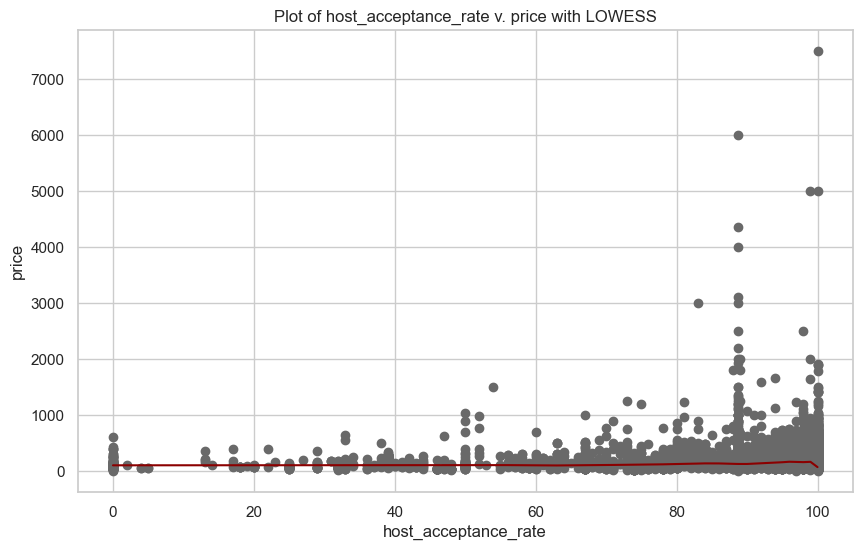

In [87]:
import statsmodels.api as sm

lowess = sm.nonparametric.lowess(eda_dkn["price"], eda_dkn["host_acceptance_rate"], frac=.3)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( eda_dkn["host_acceptance_rate"], eda_dkn["price"], marker="o", color="DimGray")
axes.plot(lowess_x, lowess_y, color="DarkRed")

axes.set_title("Plot of host_acceptance_rate v. price with LOWESS")
axes.set_xlabel( "host_acceptance_rate")
axes.set_ylabel( "price")

plt.show()
plt.close()

Through this scatterplot and the lowess line, we can see that there is a very weak postive linear relationship between host_response_rate and price. 

### Price vs Host Response Time

It is possible that the host_response_time has a negative correlation with the price since when the not hearing from the host, most people just start to look for a new ad. Because this pairwise correlation is marked by a categorical variable and a numerical variable, using summary statistics in relation to each other gives us the perspective we are looking for:

In [88]:
# describe_by_category(eda_dkn, "price", "host_response_time", transpose=True)

grouped_hot_response_rate = eda_dkn[['host_response_time', 'price']].groupby('host_response_time')
grouped_hot_response_rate_stats = grouped_hot_response_rate['price'].describe()
grouped_hot_response_rate_stats

,count,mean,std,min,25%,50%,75%,max
host_response_time,,,,,,,,
,1493.0,195.925653,315.218602,0.0,80.0,118.0,200.0,5995.0
a few days or more,91.0,200.043956,206.754815,26.0,80.0,145.0,250.0,1425.0
within a day,562.0,154.081851,341.276769,21.0,70.0,97.0,150.0,7500.0
within a few hours,1099.0,122.760692,115.499872,10.0,60.0,93.0,145.0,1500.0
within an hour,5383.0,191.701653,191.947410,0.0,99.0,147.0,225.0,5000.0


### Number of Reviews vs. Review Scores Rating

In [89]:
print('r   = ', stats.pearsonr(number_of_reviews['Average # of Reviews'], review_scores_rating['Average Review Scores'])[0])
print('rho = ', stats.spearmanr(number_of_reviews['Average # of Reviews'], review_scores_rating['Average Review Scores'])[0])

r   =  0.3357170561338624
rho =  0.5298537692258698


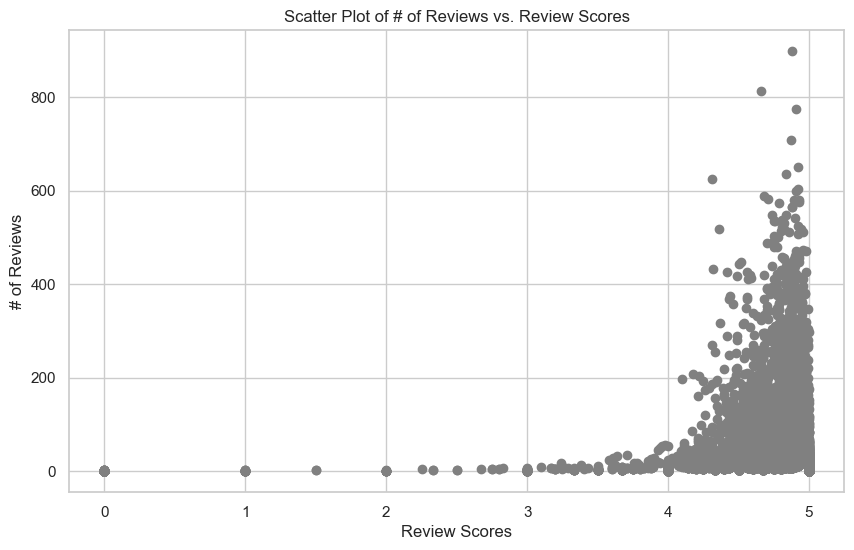

In [90]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(review_scores_rating['Average Review Scores'], number_of_reviews['Average # of Reviews'], marker='o', color='gray')

axes.set_ylabel('# of Reviews')
axes.set_xlabel('Review Scores')
axes.set_title('Scatter Plot of # of Reviews vs. Review Scores')

plt.show()
plt.close()

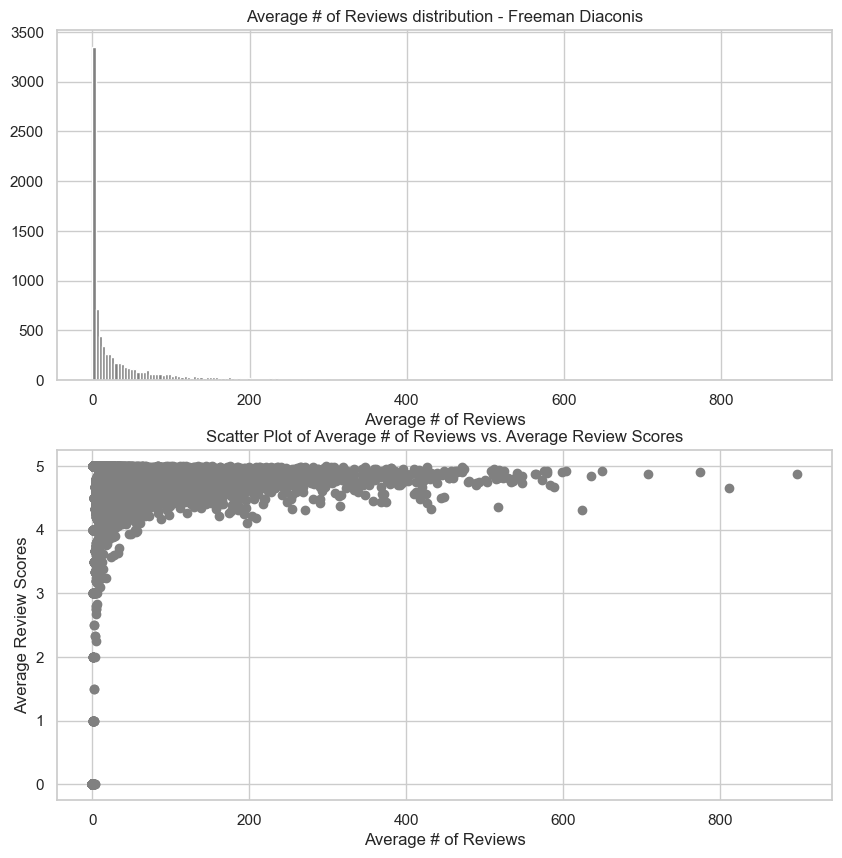

In [91]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(2, 1, 1)
axes.hist(number_of_reviews['Average # of Reviews'],bins=bins,color="gray")
axes.set_title("Average # of Reviews distribution - Freeman Diaconis")
axes.set_xlabel("Average # of Reviews")

axes = figure.add_subplot(2, 1, 2)
axes.scatter(number_of_reviews['Average # of Reviews'], review_scores_rating['Average Review Scores'], marker="o", color="gray")

axes.set_ylabel("Average Review Scores")
axes.set_xlabel("Average # of Reviews")
axes.set_title("Scatter Plot of Average # of Reviews vs. Average Review Scores")

plt.show()
plt.close()

### Number of Reviews vs. Reviews Per Month

In [92]:
print('r   = ', stats.pearsonr(number_of_reviews['Average # of Reviews'], reviews_per_month['Average Reviews Per Month'])[0])
print('rho = ', stats.spearmanr(number_of_reviews['Average # of Reviews'], reviews_per_month['Average Reviews Per Month'])[0])

r   =  0.6265832936847355
rho =  0.8776426721335399


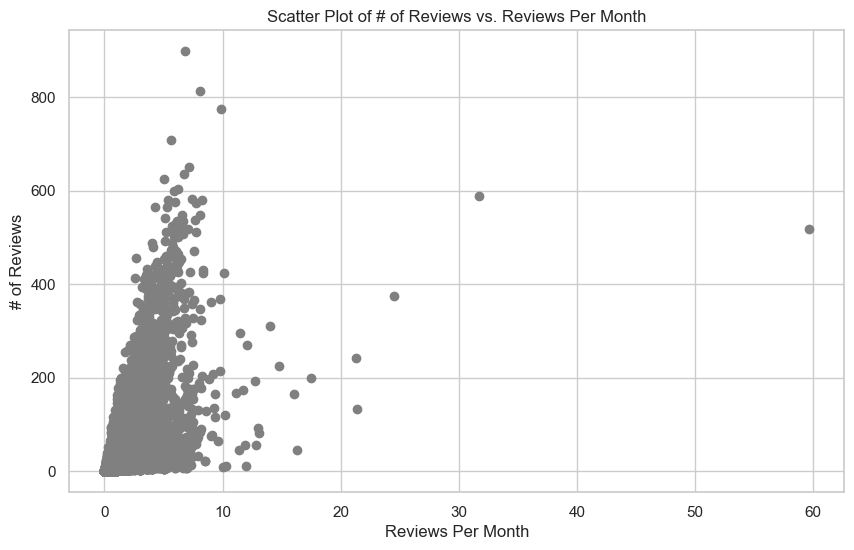

In [93]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(reviews_per_month['Average Reviews Per Month'], number_of_reviews['Average # of Reviews'], marker='o', color='gray')

axes.set_ylabel('# of Reviews')
axes.set_xlabel('Reviews Per Month')
axes.set_title('Scatter Plot of # of Reviews vs. Reviews Per Month')

plt.show()
plt.close()

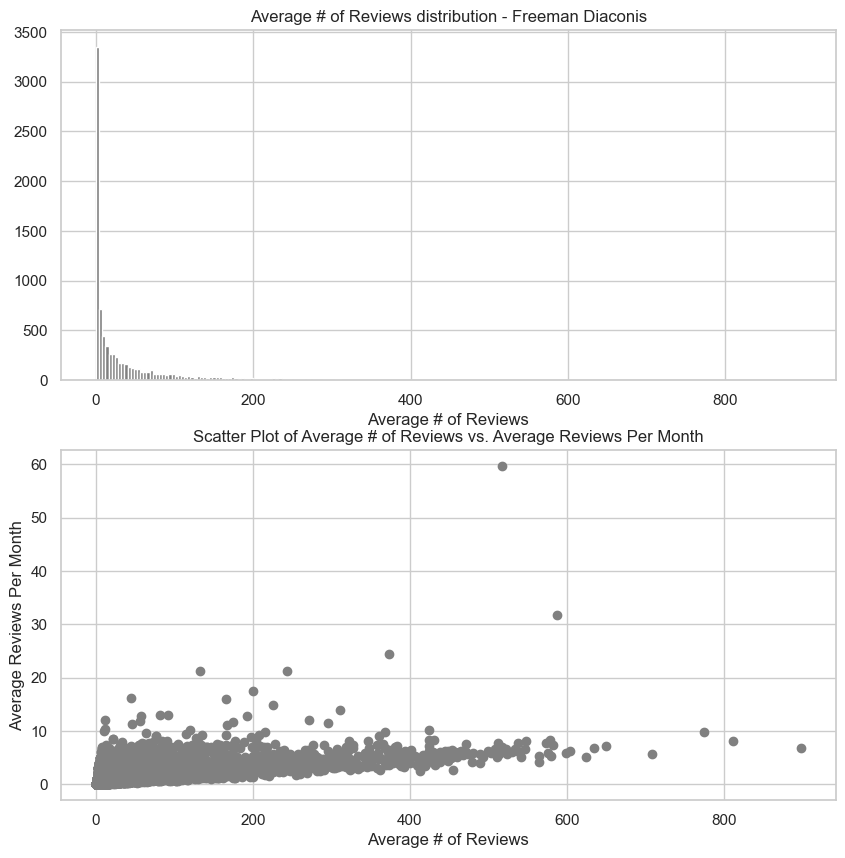

In [94]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(2, 1, 1)
axes.hist(number_of_reviews['Average # of Reviews'],bins=bins,color="gray")
axes.set_title("Average # of Reviews distribution - Freeman Diaconis")
axes.set_xlabel("Average # of Reviews")

axes = figure.add_subplot(2, 1, 2)
axes.scatter(number_of_reviews['Average # of Reviews'], reviews_per_month['Average Reviews Per Month'], marker="o", color="gray")

axes.set_ylabel("Average Reviews Per Month")
axes.set_xlabel("Average # of Reviews")
axes.set_title("Scatter Plot of Average # of Reviews vs. Average Reviews Per Month")

plt.show()
plt.close()

### Review Scores Rating vs. Reviews Per Month

In [95]:
print('r   = ', stats.pearsonr(review_scores_rating['Average Review Scores'], reviews_per_month['Average Reviews Per Month'])[0])
print('rho = ', stats.spearmanr(review_scores_rating['Average Review Scores'], reviews_per_month['Average Reviews Per Month'])[0])

r   =  0.40533783014688113
rho =  0.5616047857699558


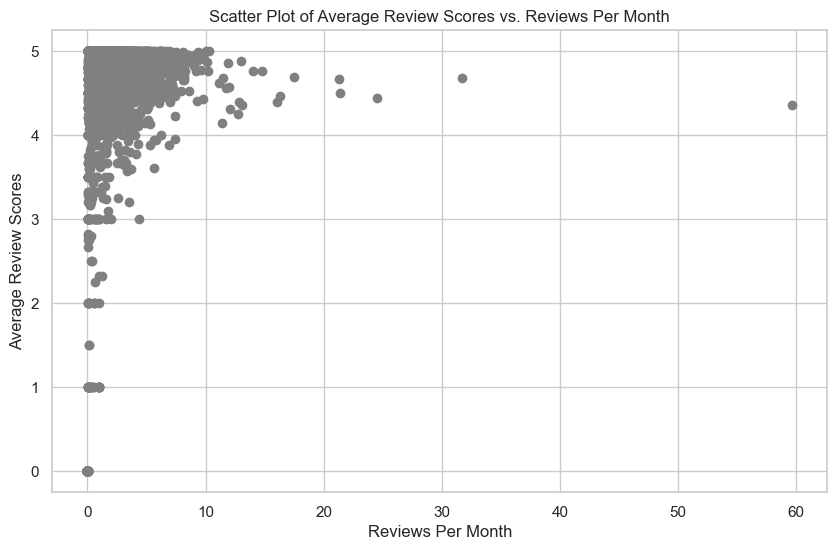

In [96]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(reviews_per_month['Average Reviews Per Month'], review_scores_rating['Average Review Scores'], marker='o', color='gray')

axes.set_ylabel('Average Review Scores')
axes.set_xlabel('Reviews Per Month')
axes.set_title('Scatter Plot of Average Review Scores vs. Reviews Per Month')

plt.show()
plt.close()

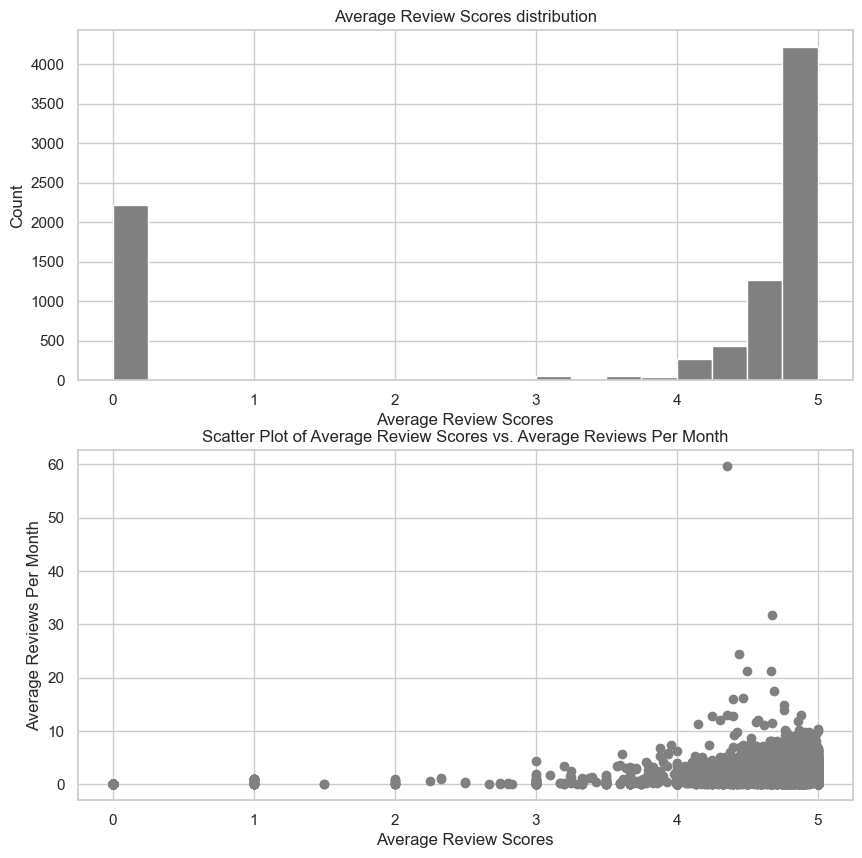

In [97]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(2, 1, 1)
axes.hist(review_scores_rating['Average Review Scores'], color='gray', bins=20)
axes.set_ylabel('Count')
axes.set_xlabel('Average Review Scores')
axes.set_title('Average Review Scores distribution')

axes = figure.add_subplot(2, 1, 2)
axes.scatter(review_scores_rating['Average Review Scores'], reviews_per_month['Average Reviews Per Month'], marker="o", color="gray")

axes.set_ylabel("Average Reviews Per Month")
axes.set_xlabel("Average Review Scores")
axes.set_title("Scatter Plot of Average Review Scores vs. Average Reviews Per Month")

plt.show()
plt.close()

While this is a categorical variable, it seems some of the listing property types have unique names/titles that only relate to one or a few listings, causing a large number of buckets/options.

### Price vs Room Type

In [98]:
db_path = './datawarehouse.db'
con=sqlite3.connect(db_path)
cur = con.cursor()

sql_query = pd.read_sql_query('''SELECT room_type, property_type, instant_bookable, price
FROM listings''', con)

df = pd.DataFrame(sql_query, columns = ['room_type', 'price', 'instant_bookable', 'property_type'])
df

df["price"] = df["price"].replace("[$,]", "", regex=True).astype(float)

In [99]:
grouped_price_room_type = df[['room_type', 'price']].groupby('room_type')
grouped_price_room_type_stats = grouped_price_room_type['price'].describe()
grouped_price_room_type_stats


table = tabulate(grouped_price_room_type_stats, 
             headers=('Room Type', 'Count', 'Mean', 'Stdev', 'Min', '25%', '50%', '75%', 'Max'),
            tablefmt='fancy_grid')
print(table)
print('\n')

╒═════════════════╤═════════╤══════════╤══════════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ Room Type       │   Count │     Mean │    Stdev │   Min │   25% │   50% │   75% │   Max │
╞═════════════════╪═════════╪══════════╪══════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ Entire home/apt │    6455 │ 202.196  │ 238.344  │    10 │   105 │   150 │ 228   │  7500 │
├─────────────────┼─────────┼──────────┼──────────┼───────┼───────┼───────┼───────┼───────┤
│ Hotel room      │      22 │  59.9545 │ 106.886  │     0 │    25 │    27 │  29   │   489 │
├─────────────────┼─────────┼──────────┼──────────┼───────┼───────┼───────┼───────┼───────┤
│ Private room    │    2028 │ 123.777  │ 167.238  │    20 │    52 │    75 │ 114   │  2000 │
├─────────────────┼─────────┼──────────┼──────────┼───────┼───────┼───────┼───────┼───────┤
│ Shared room     │     123 │  54.0244 │  25.0882 │    16 │    35 │    45 │  63.5 │   140 │
╘═════════════════╧═════════╧══════════╧══════════╧═══════╧═══════╧═══════╧═════

Entire homes/apartments are on average the most expensive ($202.20), followed by a private room ($123.78). The least expensive stay is a shared room ($54.02). The range for entire home/apartments is significantly larger/wider than the other options, ranging from $10 to $7500. This difference tells us that there are surely some extreme values in our dataset.  


### Price vs Instant Bookable

In [100]:
grouped_price_instant_bookable = df[['instant_bookable', 'price']].groupby('instant_bookable')
grouped_price_instant_bookable_stats = grouped_price_instant_bookable['price'].describe()
grouped_price_instant_bookable_stats


table2 = tabulate(grouped_price_instant_bookable_stats, 
            headers=('Instant Bookable', 'Count', 'Mean', 'Stdev', 'Min', '25%', '50%', '75%', 'Max'),
            tablefmt='fancy_grid')
print(table2)
print('\n')

╒════════════════════╤═════════╤═════════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ Instant Bookable   │   Count │    Mean │   Stdev │   Min │   25% │   50% │   75% │   Max │
╞════════════════════╪═════════╪═════════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ f                  │    5767 │ 176.207 │ 246.786 │     0 │    84 │   126 │   198 │  7500 │
├────────────────────┼─────────┼─────────┼─────────┼───────┼───────┼───────┼───────┼───────┤
│ t                  │    2861 │ 191.532 │ 171.252 │    16 │    89 │   143 │   240 │  1903 │
╘════════════════════╧═════════╧═════════╧═════════╧═══════╧═══════╧═══════╧═══════╧═══════╛




The average price of an Air BnB listing is higher for those that are instantly bookable ($191.53) compared to listings that are not instantly bookable ($176.21). Interestingly, the minimum price for a instantly bookable stay is $16, whereas the non-instantly bookable stays do not have a minimum.  


### Price vs Property Type

In [101]:
property_type_df = df[['property_type','price']]
#property_type_df

In [103]:
df_2 = pd.DataFrame(property_type_df)
df_2['property_type_2'] = '0'

df_2.loc[df_2["property_type"].str.contains('condo|loft'), "property_type_2"] = "Condo"
df_2.loc[df_2["property_type"].str.contains('apartment'), "property_type_2"] = "Apartment"
df_2.loc[df_2["property_type"].str.contains('townhouse'), "property_type_2"] = "Townhouse"
df_2.loc[df_2["property_type"].str.contains('home|place'), "property_type_2"] = "Home"
df_2.loc[df_2["property_type"].str.contains('guest suite|guesthouse'), "property_type_2"] = "Guest Suite/Guesthouse"
df_2.loc[df_2["property_type"].str.contains('rental'), "property_type_2"] = "Rental Unit"
df_2.loc[df_2["property_type"].str.contains('hotel|resort'), "property_type_2"] = "Hotel Room"
df_2.loc[df_2["property_type"].str.contains('hostel'), "property_type_2"] = "Hostel"
df_2.loc[df_2["property_type"].str.contains('villa|bungalow'), "property_type_2"] = "Villa/Bungalow"
df_2.loc[df_2["property_type"].str.contains('Cottage|cottage|Boat|Camper/RV|Campsite|Castle|Floor|Houseboat|Tent|Tower'), "property_type_2"] = "Unique Stay"
df_2.loc[df_2["property_type"].str.contains('Tiny|tiny'), "property_type_2"] = "Tiny Home"
df_2.loc[df_2["property_type"].str.contains('Breakfast|breakfast'), "property_type_2"] = "Bed & Breakfast"
df_2.loc[df_2["property_type"].str.contains('particular|aparthotel'), "property_type_2"] = "Other"
df_2.loc[df_2["property_type_2"].str.contains('0'), "property_type_2"] = "Other"

df_2.loc[df_2["property_type"].str.contains('Entire'), "property_type"] = "Entire Space"
df_2.loc[df_2["property_type"].str.contains('Private|private|apartment|breakfast'), "property_type"] = "Private Room"
df_2.loc[df_2["property_type"].str.contains('Shared|shared'), "property_type"] = "Shared Room"
df_2.loc[df_2["property_type"].str.contains('Hotel|hotel'), "property_type"] = "Hotel"
df_2.loc[df_2["property_type"].str.contains('Hostel|hostel'), "property_type"] = "Hostel"
df_2.loc[df_2["property_type"].str.contains('Boat|Camper/RV|Campsite|Casa particular|Castle|Floor|Houseboat|Tent|Tiny home|Tower'), "property_type"] = "Unique Stay"
#df_2

In [104]:
grouped_price_property_type = df_2[['property_type', 'price', 'property_type_2']].groupby('property_type')
grouped_price_property_type_stats = grouped_price_property_type['price'].describe().reset_index()
#grouped_price_property_type_stats

In [105]:
grouped_price_property_type_2 = df_2[['property_type', 'price', 'property_type_2']].groupby('property_type_2')
grouped_price_property_type_stats_2 = grouped_price_property_type_2['price'].describe().reset_index()
grouped_price_property_type_stats_2

,property_type_2,count,mean,std,min,25%,50%,75%,max
0,Apartment,660.0,224.772727,98.248577,56.0,159.0,212.0,279.00,716.0
1,Bed & Breakfast,52.0,218.980769,190.636446,25.0,75.0,141.0,300.00,799.0
2,Condo,800.0,148.437500,110.485938,29.0,88.0,125.0,175.00,1425.0
3,Guest Suite/Guesthouse,684.0,122.173977,86.339114,29.0,85.0,105.0,133.50,1237.0
4,Home,1726.0,218.380070,388.024673,10.0,65.0,120.0,250.00,7500.0
5,Hostel,33.0,84.757576,75.380713,0.0,25.0,73.0,90.00,313.0
6,Hotel Room,222.0,382.432432,304.298871,0.0,197.0,302.0,459.00,1903.0
7,Other,28.0,247.714286,123.517237,58.0,174.0,254.0,298.00,482.0
8,Rental Unit,3375.0,151.270519,122.768793,20.0,88.0,126.0,178.00,3000.0
9,Tiny Home,3.0,129.666667,34.588052,92.0,114.5,137.0,148.50,160.0


We grouped the different property types into overall categories (for example: "Apartment" includes rentals that are the entire apartment, private room of an apartment, and shared room in an apartment). There were originally 53 different categories, and we were able to pair that down to about 12 groups. Unique stays include boats, boathouse, campsite, castle, tent, camper/rv, cottage, tower, and a few other listing types. Based on the analysis results, the highest average cost is actually for hotel rooms ($382.43) and the least expensive stay is a hostel ($84.76). Interestingly, the price range for a home stay (10, 7500) and townhouse stay (20, 4357) seem fairly extreme, leading us to believe that there are some extreme values in our dataset. It is worth looking further into this variable and how it interacts with other variables such as number of rooms and location to see how those variables may influence the overall price of a listing. 